In [1]:
# # First install PyTorch with CUDA support
# !pip install --user torch torchvision torchaudio --index-url https://download.pytorch.org/whl/cu118

# # Then install transformers from regular PyPI
# !pip install --user transformers

In [ ]:
# Import all necessary libraries and load data
import pandas as pd
import numpy as np
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
from transformers import AutoTokenizer, AutoModel, get_linear_schedule_with_warmup
from torch.optim import AdamW
from sklearn.metrics import accuracy_score, precision_recall_fscore_support, classification_report, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm
import re
import os
import json
from datetime import datetime

print("Libraries imported successfully!")

Libraries imported successfully!


In [4]:

# Load the pickle files
print("Loading data...")
train_data = pd.read_pickle("./python_data/train.pkl")
test_data = pd.read_pickle("./python_data/test.pkl")
val_data = pd.read_pickle("./python_data/val.pkl")

print(f"Data loaded successfully!")
print(f"Train: {len(train_data)} samples")
print(f"Validation: {len(val_data)} samples") 
print(f"Test: {len(test_data)} samples")

# Show basic info about the data
print(f"\nColumns: {list(train_data.columns)}")
print(f"Target distribution in training:")
print(train_data['y'].value_counts())

# Show basic info about the data
print(f"\nColumns: {list(test_data.columns)}")
print(f"Target distribution in testing:")
print(test_data['y'].value_counts())

# Show basic info about the data
print(f"\nColumns: {list(val_data.columns)}")
print(f"Target distribution in validation:")
print(val_data['y'].value_counts())

Loading data...
Data loaded successfully!
Train: 172548 samples
Validation: 4220 samples
Test: 4196 samples

Columns: ['oldf', 'patch', 'msg', 'id', 'y', 'idx', 'proj', 'lang']
Target distribution in training:
y
1    132918
0     39630
Name: count, dtype: int64

Columns: ['patch', 'y', 'oldf', 'idx', 'id', 'msg', 'proj', 'lang']
Target distribution in testing:
y
0    2163
1    2033
Name: count, dtype: int64

Columns: ['patch', 'y', 'oldf', 'idx', 'id', 'msg', 'proj', 'lang']
Target distribution in validation:
y
0    2167
1    2053
Name: count, dtype: int64


In [ ]:
# Create the data preprocessor class
class CodeReviewPreprocessor:
    """
    This class cleans and processes code patches for our model.
    It converts git diff format into something our model can understand.
    """
    
    def __init__(self):
        self.max_patch_length = 512
        # Special tokens to mark different types of lines in code diffs
        self.special_tokens = {
            'ADD': '[ADD]',    # For lines that were added (+ in git diff)
            'DEL': '[DEL]',    # For lines that were deleted (- in git diff)  
            'KEEP': '[KEEP]',  # For unchanged context lines
            'SEP': '[SEP]'     # For separator lines (@@)
        }
    
    def clean_patch(self, patch):
        """Convert git diff format to our special token format"""
        if pd.isna(patch) or patch == '':
            return ''
        
        # Clean up whitespace
        patch = re.sub(r'\s+', ' ', patch)
        
        # Process each line in the diff
        lines = patch.split('\n')
        processed_lines = []
        
        for line in lines:
            line = line.strip()
            if line == '':
                continue
            elif line.startswith('@@'):
                # Context line (shows line numbers)  
                processed_lines.append(f"{self.special_tokens['SEP']} {line}")
            elif line.startswith('+'):
                # Added line
                content = line[1:].strip()  # Remove the + symbol
                processed_lines.append(f"{self.special_tokens['ADD']} {content}")
            elif line.startswith('-'):
                # Deleted line
                content = line[1:].strip()  # Remove the - symbol
                processed_lines.append(f"{self.special_tokens['DEL']} {content}")
            else:
                # Unchanged context line
                processed_lines.append(f"{self.special_tokens['KEEP']} {line}")
        
        return ' '.join(processed_lines)
    
    def extract_numerical_features(self, df):
        """Extract numerical features from the data"""
        features = pd.DataFrame()
        
        # Count characters in patch
        features['patch_length'] = df['patch'].fillna('').str.len()
        
        # Count additions and deletions
        features['num_additions'] = df['patch'].fillna('').str.count(r'\+[^@]')
        features['num_deletions'] = df['patch'].fillna('').str.count(r'\-[^@]') 
        features['total_changes'] = features['num_additions'] + features['num_deletions']
        
        # Message features
        features['has_message'] = (df['msg'].fillna('').str.len() > 0).astype(int)
        features['message_length'] = df['msg'].fillna('').str.len()
        
        # Language features  
        features['is_python'] = (df['lang'] == 'py').astype(int)
        features['is_undefined_lang'] = (df['lang'] == 'undefined').astype(int)
        
        return features
    
    def preprocess_dataset(self, df):
        """Main preprocessing function"""
        print(f"Processing {len(df)} samples...")
        
        # Make a clean copy and remove any duplicate columns
        df_clean = df.copy()
        df_clean = df_clean.loc[:, ~df_clean.columns.duplicated()]
        
        # Clean the patches
        print("Converting patches to special token format...")
        df_clean['processed_patch'] = df_clean['patch'].apply(self.clean_patch)
        
        # Extract numerical features
        print("Extracting numerical features...")
        numerical_features = self.extract_numerical_features(df_clean)
        
        # Combine everything
        result = df_clean[['patch', 'processed_patch', 'msg', 'y', 'lang', 'proj']].copy()
        for col in numerical_features.columns:
            result[col] = numerical_features[col]
            
        print(f"Preprocessing complete! Final shape: {result.shape}")
        return result

# Initialize the preprocessor
preprocessor = CodeReviewPreprocessor()
print("Preprocessor created successfully!")

# Test on a small sample to make sure it works
print("\nTesting preprocessor on 5 samples...")
test_sample = train_data.head(5)
test_result = preprocessor.preprocess_dataset(test_sample)
print("Test successful!")
print(f"Sample processed patch: {test_result['processed_patch'].iloc[0]}...")

Preprocessor created successfully!

Testing preprocessor on 5 samples...
Processing 5 samples...
Converting patches to special token format...
Extracting numerical features...
Preprocessing complete! Final shape: (5, 14)
Test successful!
Sample processed patch: [SEP] @@ -91,7 +91,7 @@ std::vector<std::string> WalletManagerImpl::findWallets(const std::string &path) boost::filesystem::path work_dir(path); // return empty result if path doesn't exist if(!boost::filesystem::is_directory(path)){ - return result; + return result; } const boost::regex wallet_rx("(.*)\\.(keys)$"); // searching for <wallet_name>.keys files boost::filesystem::recursive_directory_iterator end_itr; // Default ctor yields past-the-end...


In [6]:
# Cell 3: Process all datasets
print("Processing all datasets...")
print("This might take a few minutes...")

# Process each dataset
print("\n1. Processing training data...")
train_processed = preprocessor.preprocess_dataset(train_data)

print("\n2. Processing validation data...")
val_processed = preprocessor.preprocess_dataset(val_data)

print("\n3. Processing test data...")  
test_processed = preprocessor.preprocess_dataset(test_data)

print(f"\nAll data processed successfully!")
print(f"Train: {len(train_processed)} samples")
print(f"Val: {len(val_processed)} samples")
print(f"Test: {len(test_processed)} samples")

# Show what our processed data looks like
print(f"\nProcessed data columns: {list(train_processed.columns)}")

# Check target distribution
print(f"\nTarget distribution (1=needs review, 0=no review needed):")
for dataset_name, dataset in [("Train", train_processed), ("Val", val_processed), ("Test", test_processed)]:
    dist = dataset['y'].value_counts().sort_index()
    total = len(dataset)
    print(f"{dataset_name}: No review: {dist[0]} ({dist[0]/total*100:.1f}%), Review needed: {dist[1]} ({dist[1]/total*100:.1f}%)")

# Show some statistics about our numerical features
print(f"\nNumerical features statistics:")
feature_cols = ['patch_length', 'num_additions', 'num_deletions', 'total_changes', 'message_length']
print(train_processed[feature_cols].describe())

Processing all datasets...
This might take a few minutes...

1. Processing training data...
Processing 172548 samples...
Converting patches to special token format...
Extracting numerical features...
Preprocessing complete! Final shape: (172548, 14)

2. Processing validation data...
Processing 4220 samples...
Converting patches to special token format...
Extracting numerical features...
Preprocessing complete! Final shape: (4220, 14)

3. Processing test data...
Processing 4196 samples...
Converting patches to special token format...
Extracting numerical features...
Preprocessing complete! Final shape: (4196, 14)

All data processed successfully!
Train: 172548 samples
Val: 4220 samples
Test: 4196 samples

Processed data columns: ['patch', 'processed_patch', 'msg', 'y', 'lang', 'proj', 'patch_length', 'num_additions', 'num_deletions', 'total_changes', 'has_message', 'message_length', 'is_python', 'is_undefined_lang']

Target distribution (1=needs review, 0=no review needed):
Train: No re

In [ ]:
# Define our model and dataset classes

class CodeReviewDataset(Dataset):
    """
    Dataset class that handles:
    1. Converting text to tokens that the model can understand
    2. Preparing numerical features
    3. Returning everything in the right format for training
    """
    
    def __init__(self, df, tokenizer, max_length=256):
        self.df = df.reset_index(drop=True)
        self.tokenizer = tokenizer
        self.max_length = max_length
        
    def __len__(self):
        return len(self.df)
    
    def __getitem__(self, idx):
        row = self.df.iloc[idx]
        
        # Get the processed patch text
        patch_text = str(row['processed_patch'])
        
        # Convert text to numbers that the model can understand
        encoding = self.tokenizer(
            patch_text,
            truncation=True,  # Cut off if too long
            padding='max_length',  # Add padding if too short
            max_length=self.max_length,
            return_tensors='pt'
        )
        
        # Get numerical features safely
        def safe_float(col_name, default=0.0):
            try:
                val = row[col_name] 
                return float(val) if not pd.isna(val) else default
            except:
                return default
        
        # Prepare numerical features
        numerical_features = torch.tensor([
            safe_float('patch_length'),
            safe_float('num_additions'), 
            safe_float('num_deletions'),
            safe_float('total_changes'),
            safe_float('has_message'),
            safe_float('message_length'),
            safe_float('is_python'),
            safe_float('is_undefined_lang')
        ], dtype=torch.float32)
        
        return {
            'input_ids': encoding['input_ids'].flatten(),
            'attention_mask': encoding['attention_mask'].flatten(), 
            'numerical_features': numerical_features,
            'labels': torch.tensor(int(row['y']), dtype=torch.long)
        }

class CodeReviewClassifier(nn.Module):
    """
    Our neural network model that combines:
    1. CodeBERT (understands code) for processing the patch text
    2. A small network for numerical features  
    3. A classifier that combines both to make the final prediction
    """
    
    def __init__(self, model_name='microsoft/codebert-base', num_numerical_features=8):
        super().__init__()
        
        # Load pre-trained CodeBERT (knows about code already)
        self.codebert = AutoModel.from_pretrained(model_name)
        self.codebert_dim = self.codebert.config.hidden_size  # Usually 768
        
        # Small network to process numerical features
        self.numerical_processor = nn.Sequential(
            nn.Linear(num_numerical_features, 64),
            nn.ReLU(),
            nn.Dropout(0.2),
            nn.Linear(64, 32),
            nn.ReLU()
        )
        
        # Final classifier that combines everything
        combined_dim = self.codebert_dim + 32  # 768 + 32 = 800
        self.classifier = nn.Sequential(
            nn.Linear(combined_dim, 256),
            nn.ReLU(),
            nn.Dropout(0.3),
            nn.Linear(256, 128), 
            nn.ReLU(),
            nn.Dropout(0.2),
            nn.Linear(128, 2)  # 2 classes: needs review or not
        )
        
    def forward(self, input_ids, attention_mask, numerical_features):
        # Process the code patch with CodeBERT
        codebert_output = self.codebert(
            input_ids=input_ids,
            attention_mask=attention_mask
        )
        # Use the [CLS] token representation (summary of the whole sequence)
        code_features = codebert_output.last_hidden_state[:, 0, :]  # Shape: [batch_size, 768]
        
        # Process numerical features
        numerical_processed = self.numerical_processor(numerical_features)  # Shape: [batch_size, 32]
        
        # Combine both types of features
        combined_features = torch.cat([code_features, numerical_processed], dim=1)  # Shape: [batch_size, 800]
        
        # Make final prediction
        logits = self.classifier(combined_features)  # Shape: [batch_size, 2]
        
        return logits

print("Model and dataset classes defined successfully!")

# Initialize tokenizer and add our special tokens
print("Loading tokenizer...")
model_name = 'microsoft/codebert-base'
tokenizer = AutoTokenizer.from_pretrained(model_name)

# Add our special tokens
special_tokens = ['[ADD]', '[DEL]', '[KEEP]', '[SEP]']
tokenizer.add_special_tokens({'additional_special_tokens': special_tokens})
print(f"Tokenizer loaded with {len(tokenizer)} tokens")

# Initialize model
print("Creating model...")
model = CodeReviewClassifier(model_name=model_name, num_numerical_features=8)
model.codebert.resize_token_embeddings(len(tokenizer))  # Adjust for new tokens

total_params = sum(p.numel() for p in model.parameters())
print(f"Model created with {total_params:,} parameters")

print("Ready for training setup!")

Model and dataset classes defined successfully!
Loading tokenizer...
Tokenizer loaded with 50269 tokens
Creating model...


2025-08-13 18:14:43.306752: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1755123283.333270  433702 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1755123283.338363  433702 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2025-08-13 18:14:43.355760: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
The new embeddings will be initialized from a multivariate normal distribution that has old embeddings' mean and covariance. 

Model created with 124,889,570 parameters
Ready for training setup!


In [ ]:
# Create data loaders for training

# initial training
TRAIN_SAMPLE_SIZE = len(train_processed)//4  
VAL_SAMPLE_SIZE = len(val_processed)
TEST_SAMPLE_SIZE = len(test_processed)

if torch.cuda.is_available():
    gpu_memory = torch.cuda.get_device_properties(0).total_memory / 1e9
    BATCH_SIZE = 64 if gpu_memory < 16 else 128 if gpu_memory < 32 else 256
else:
    BATCH_SIZE = 128
print(f"Using batch size: {BATCH_SIZE}")

print(f"Creating data samples...")
print(f"Using {TRAIN_SAMPLE_SIZE} training samples (out of {len(train_processed)} available)")
print(f"Using {VAL_SAMPLE_SIZE} validation samples (out of {len(val_processed)} available)")
print(f"Using {TEST_SAMPLE_SIZE} test samples (out of {len(test_processed)} available)")

# Sample the data
train_sample = train_processed.sample(
    n=min(TRAIN_SAMPLE_SIZE, len(train_processed)), 
    random_state=42
)
val_sample = val_processed.sample(
    n=min(VAL_SAMPLE_SIZE, len(val_processed)), 
    random_state=42
)
test_sample = test_processed.sample(
    n=min(TEST_SAMPLE_SIZE, len(test_processed)), 
    random_state=42
)

print(f"Samples created:")
print(f"  Train: {len(train_sample)} samples")
print(f"  Val: {len(val_sample)} samples") 
print(f"  Test: {len(test_sample)} samples")

# Check class distribution in our samples
print(f"\nClass distribution in training sample:")
train_dist = train_sample['y'].value_counts()
print(f"  No Review (0): {train_dist[0]} ({train_dist[0]/len(train_sample)*100:.1f}%)")
print(f"  Review Needed (1): {train_dist[1]} ({train_dist[1]/len(train_sample)*100:.1f}%)")

# Create datasets
print(f"\nCreating PyTorch datasets...")
train_dataset = CodeReviewDataset(train_sample, tokenizer, max_length=256)
val_dataset = CodeReviewDataset(val_sample, tokenizer, max_length=256)
test_dataset = CodeReviewDataset(test_sample, tokenizer, max_length=256)

# Create data loaders
print(f"Creating data loaders with batch size {BATCH_SIZE}...")
train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False)

print(f"Data loaders created:")
print(f"  Train batches: {len(train_loader)}")
print(f"  Val batches: {len(val_loader)}")
print(f"  Test batches: {len(test_loader)}")

# Testing that everything works by loading one batch
print(f"\nTesting data loading...")
try:
    batch = next(iter(train_loader))
    print(f"✓ Success! Batch loaded successfully")
    print(f"  Input IDs shape: {batch['input_ids'].shape}")
    print(f"  Attention mask shape: {batch['attention_mask'].shape}")
    print(f"  Numerical features shape: {batch['numerical_features'].shape}")
    print(f"  Labels shape: {batch['labels'].shape}")
    print(f"  Sample labels: {batch['labels'][:5]}")  
except Exception as e:
    print(f"✗ Error loading batch: {e}")
    raise e

print(f"\nReady for training!")

Using batch size: 64
Creating data samples...
Using 43137 training samples (out of 172548 available)
Using 4220 validation samples (out of 4220 available)
Using 4196 test samples (out of 4196 available)
Samples created:
  Train: 43137 samples
  Val: 4220 samples
  Test: 4196 samples

Class distribution in training sample:
  No Review (0): 9901 (23.0%)
  Review Needed (1): 33236 (77.0%)

Creating PyTorch datasets...
Creating data loaders with batch size 64...
Data loaders created:
  Train batches: 675
  Val batches: 66
  Test batches: 66

Testing data loading...
✓ Success! Batch loaded successfully
  Input IDs shape: torch.Size([64, 256])
  Attention mask shape: torch.Size([64, 256])
  Numerical features shape: torch.Size([64, 8])
  Labels shape: torch.Size([64])
  Sample labels: tensor([1, 1, 1, 1, 1])

Ready for training!


In [ ]:
# Define training functions

def train_one_epoch(model, train_loader, optimizer, scheduler, device, epoch_num):
    """Train the model for one epoch"""
    model.train()  
    total_loss = 0
    all_predictions = []
    all_labels = []
    
    # Progress bar to see training progress
    progress_bar = tqdm(train_loader, desc=f'Training Epoch {epoch_num}')
    
    for batch in progress_bar:
        # Move data to GPU/CPU
        input_ids = batch['input_ids'].to(device)
        attention_mask = batch['attention_mask'].to(device)
        numerical_features = batch['numerical_features'].to(device)
        labels = batch['labels'].to(device)
        
        # Reset gradients
        optimizer.zero_grad()
        
        # Forward pass: get model predictions
        logits = model(input_ids, attention_mask, numerical_features)
        
        # Calculate loss (how wrong the predictions are)
        loss = nn.CrossEntropyLoss()(logits, labels)
        
        # Backward pass: calculate gradients
        loss.backward()
        
        # Prevent gradients from getting too large
        torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
        
        # Update model weights
        optimizer.step()
        scheduler.step()
        
        # Track metrics
        total_loss += loss.item()
        predictions = torch.argmax(logits, dim=1).cpu().numpy()
        true_labels = labels.cpu().numpy()
        
        all_predictions.extend(predictions)
        all_labels.extend(true_labels)
        
        # Update progress bar
        progress_bar.set_postfix({'loss': f'{loss.item():.4f}'})
    
    # Calculate average loss and accuracy for the epoch
    avg_loss = total_loss / len(train_loader)
    accuracy = accuracy_score(all_labels, all_predictions)

    # Add this before the return statement:
    if device.type == 'cuda':
        torch.cuda.empty_cache()
    
    return avg_loss, accuracy

def evaluate_model(model, data_loader, device, description="Evaluating"):
    """Evaluate the model on validation or test data"""
    model.eval()  # Put model in evaluation mode
    total_loss = 0
    all_predictions = []
    all_labels = []
    
    # Don't calculate gradients during evaluation
    with torch.no_grad():
        progress_bar = tqdm(data_loader, desc=description)
        
        for batch in progress_bar:
            # Move data to device
            input_ids = batch['input_ids'].to(device)
            attention_mask = batch['attention_mask'].to(device)
            numerical_features = batch['numerical_features'].to(device)
            labels = batch['labels'].to(device)
            
            # Get predictions
            logits = model(input_ids, attention_mask, numerical_features)
            
            # Calculate loss
            loss = nn.CrossEntropyLoss()(logits, labels)
            total_loss += loss.item()
            
            # Get predictions
            predictions = torch.argmax(logits, dim=1).cpu().numpy()
            true_labels = labels.cpu().numpy()
            
            all_predictions.extend(predictions)
            all_labels.extend(true_labels)
    
    # Calculate metrics
    avg_loss = total_loss / len(data_loader)
    accuracy = accuracy_score(all_labels, all_predictions)
    precision, recall, f1, _ = precision_recall_fscore_support(all_labels, all_predictions, average='weighted')
    
    return avg_loss, accuracy, precision, recall, f1, all_predictions, all_labels

print("Training functions defined successfully!")
print("Functions created:")
print("  - train_one_epoch(): Trains model for one epoch")
print("  - evaluate_model(): Evaluates model performance")

Training functions defined successfully!
Functions created:
  - train_one_epoch(): Trains model for one epoch
  - evaluate_model(): Evaluates model performance


In [ ]:
# Train the model

# Training settings
NUM_EPOCHS = 6
LEARNING_RATE = 2e-5

print("=" * 60)
print("STARTING MODEL TRAINING")
print("=" * 60)

# Set up device (GPU if available, otherwise CPU)
if torch.cuda.is_available():
    device = torch.device('cuda:0')
    print(f"✅ Using GPU: {torch.cuda.get_device_name()}")
    print(f"✅ GPU Memory: {torch.cuda.get_device_properties(0).total_memory / 1e9:.1f} GB")
else:
    device = torch.device('cpu')
    print("⚠️ CUDA not available, using CPU")
    
print(f"Using device: {device}")

# Move model to device
model = model.to(device)
# Add memory management
if device.type == 'cuda':
    torch.cuda.empty_cache()
    print(f"Initial GPU memory allocated: {torch.cuda.memory_allocated()/1e9:.2f} GB")

# Set up optimizer (updates the model weights)
optimizer = AdamW(model.parameters(), lr=LEARNING_RATE, weight_decay=0.01)

# Set up learning rate scheduler (adjusts learning rate during training)
total_steps = len(train_loader) * NUM_EPOCHS
scheduler = get_linear_schedule_with_warmup(
    optimizer,
    num_warmup_steps=int(0.1 * total_steps),  # 10% warmup
    num_training_steps=total_steps
)

print(f"Training setup:")
print(f"  Epochs: {NUM_EPOCHS}")
print(f"  Learning rate: {LEARNING_RATE}")
print(f"  Total training steps: {total_steps}")
print(f"  Batch size: {BATCH_SIZE}")

# Keep track of training progress
training_history = {
    'train_losses': [],
    'train_accuracies': [],
    'val_losses': [],
    'val_accuracies': [],
    'val_f1_scores': []
}

best_val_f1 = 0
best_model_state = None

# Training loop
for epoch in range(NUM_EPOCHS):
    print(f"\nEpoch {epoch + 1}/{NUM_EPOCHS}")
    print("-" * 40)
    
    # Train for one epoch
    train_loss, train_acc = train_one_epoch(
        model, train_loader, optimizer, scheduler, device, epoch + 1
    )
    
    # Evaluate on validation set
    val_loss, val_acc, val_precision, val_recall, val_f1, val_preds, val_true = evaluate_model(
        model, val_loader, device, "Validating"
    )
    
    # Save metrics
    training_history['train_losses'].append(train_loss)
    training_history['train_accuracies'].append(train_acc)
    training_history['val_losses'].append(val_loss)
    training_history['val_accuracies'].append(val_acc)
    training_history['val_f1_scores'].append(val_f1)
    
    # Save best model
    if val_f1 > best_val_f1:
        best_val_f1 = val_f1
        best_model_state = model.state_dict().copy()
        print("  ✓ New best model saved!")
    
    # Print results
    print(f"  Train Loss: {train_loss:.4f}, Train Accuracy: {train_acc:.4f}")
    print(f"  Val Loss: {val_loss:.4f}, Val Accuracy: {val_acc:.4f}")
    print(f"  Val Precision: {val_precision:.4f}, Val Recall: {val_recall:.4f}, Val F1: {val_f1:.4f}")

# Load the best model
if best_model_state is not None:
    model.load_state_dict(best_model_state)
    print(f"\n✓ Loaded best model with validation F1: {best_val_f1:.4f}")
    
    # ADD THIS: Save checkpoint immediately
    checkpoint = {
        'epoch': epoch + 1,
        'model_state_dict': model.state_dict(),
        'optimizer_state_dict': optimizer.state_dict(),
        'scheduler_state_dict': scheduler.state_dict(),
        'best_val_f1': best_val_f1,
        'training_history': training_history
    }
    torch.save(checkpoint, f"code_review_model/best_checkpoint_epoch_{epoch+1}.pt")
    print(f"  ✓ Checkpoint saved: best_checkpoint_epoch_{epoch+1}.pt")

print("\n" + "=" * 60)
print("TRAINING COMPLETED!")
print("=" * 60)
print(f"Best validation F1 score: {best_val_f1:.4f}")

# Show final validation results
print(f"\nFinal Validation Classification Report:")
print(classification_report(val_true, val_preds, 
                          target_names=['No Review Needed', 'Review Needed']))

STARTING MODEL TRAINING
✅ Using GPU: Tesla P100-PCIE-12GB
✅ GPU Memory: 12.8 GB
Using device: cuda:0
Initial GPU memory allocated: 0.50 GB
Training setup:
  Epochs: 6
  Learning rate: 2e-05
  Total training steps: 4050
  Batch size: 64

Epoch 1/6
----------------------------------------


Validating: 100%|██████████| 66/66 [00:40<00:00,  1.63it/s]


  ✓ New best model saved!
  Train Loss: 0.4475, Train Accuracy: 0.8124
  Val Loss: 0.5504, Val Accuracy: 0.7268
  Val Precision: 0.7942, Val Recall: 0.7268, Val F1: 0.7075

Epoch 2/6
----------------------------------------


Validating: 100%|██████████| 66/66 [00:40<00:00,  1.63it/s]


  ✓ New best model saved!
  Train Loss: 0.2173, Train Accuracy: 0.9094
  Val Loss: 0.4058, Val Accuracy: 0.8185
  Val Precision: 0.8513, Val Recall: 0.8185, Val F1: 0.8132

Epoch 3/6
----------------------------------------


Validating: 100%|██████████| 66/66 [00:40<00:00,  1.63it/s]


  ✓ New best model saved!
  Train Loss: 0.1723, Train Accuracy: 0.9299
  Val Loss: 0.3458, Val Accuracy: 0.8583
  Val Precision: 0.8788, Val Recall: 0.8583, Val F1: 0.8558

Epoch 4/6
----------------------------------------


Validating: 100%|██████████| 66/66 [00:40<00:00,  1.63it/s]


  ✓ New best model saved!
  Train Loss: 0.1453, Train Accuracy: 0.9426
  Val Loss: 0.3284, Val Accuracy: 0.8713
  Val Precision: 0.8828, Val Recall: 0.8713, Val F1: 0.8700

Epoch 5/6
----------------------------------------


Validating: 100%|██████████| 66/66 [00:40<00:00,  1.63it/s]


  ✓ New best model saved!
  Train Loss: 0.1211, Train Accuracy: 0.9530
  Val Loss: 0.3353, Val Accuracy: 0.8746
  Val Precision: 0.8782, Val Recall: 0.8746, Val F1: 0.8741

Epoch 6/6
----------------------------------------


Validating: 100%|██████████| 66/66 [00:40<00:00,  1.63it/s]


  Train Loss: 0.1028, Train Accuracy: 0.9607
  Val Loss: 0.3714, Val Accuracy: 0.8557
  Val Precision: 0.8632, Val Recall: 0.8557, Val F1: 0.8546

✓ Loaded best model with validation F1: 0.8741
  ✓ Checkpoint saved: best_checkpoint_epoch_6.pt

TRAINING COMPLETED!
Best validation F1 score: 0.8741

Final Validation Classification Report:
                  precision    recall  f1-score   support

No Review Needed       0.81      0.93      0.87      2167
   Review Needed       0.91      0.78      0.84      2053

        accuracy                           0.86      4220
       macro avg       0.86      0.85      0.85      4220
    weighted avg       0.86      0.86      0.85      4220



In [16]:
# Create directory and save the trained model
os.makedirs("code_review_model", exist_ok=True)

# Save the current best model
checkpoint = {
    'model_state_dict': model.state_dict(),
    'best_val_f1': best_val_f1,
    'training_history': training_history
}
torch.save(checkpoint, "code_review_model/trained_model.pt")
print("✅ Model saved successfully!")

✅ Model saved successfully!


GPU memory before evaluation: 2.04 GB
FINAL MODEL EVALUATION
Evaluating on test set...


Testing: 100%|██████████| 66/66 [00:40<00:00,  1.64it/s]



FINAL TEST RESULTS:
  Test Loss: 0.3974
  Test Accuracy: 0.8575
  Test Precision: 0.8624
  Test Recall: 0.8575
  Test F1: 0.8567

Detailed Test Classification Report:
                  precision    recall  f1-score   support

No Review Needed       0.82      0.92      0.87      2163
   Review Needed       0.90      0.79      0.84      2033

        accuracy                           0.86      4196
       macro avg       0.86      0.86      0.86      4196
    weighted avg       0.86      0.86      0.86      4196


Creating visualizations...


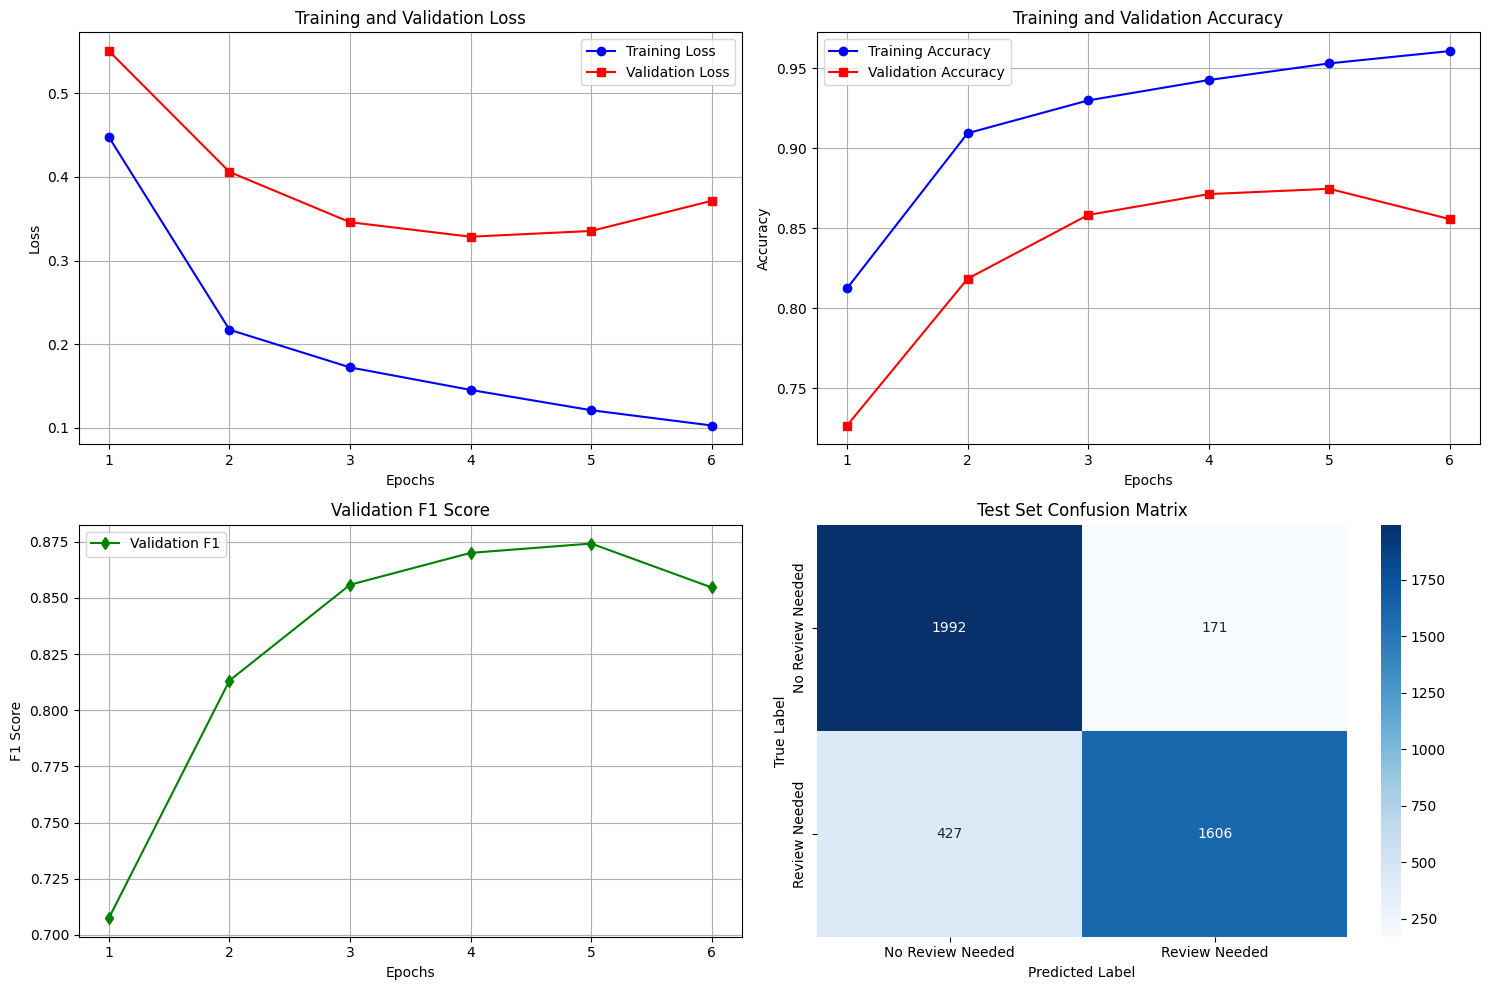


TRAINING SUMMARY
Dataset sizes used:
  Training: 43,137 samples
  Validation: 4,220 samples
  Test: 4,196 samples

Final Performance:
  Best Validation F1: 0.8741
  Test F1: 0.8567
  Test Accuracy: 0.8575

Confusion Matrix Analysis:
  True Negatives (correctly predicted no review): 1992
  False Positives (incorrectly predicted review needed): 171
  False Negatives (missed cases that needed review): 427
  True Positives (correctly predicted review needed): 1606
  Specificity (correct 'no review' rate): 0.9209
  Sensitivity (correct 'review needed' rate): 0.7900

✓ Model evaluation complete!


In [ ]:
# Test the final model and visualize results

if device.type == 'cuda':
    print(f"GPU memory before evaluation: {torch.cuda.memory_allocated()/1e9:.2f} GB")
    torch.cuda.empty_cache()

print("=" * 60)
print("FINAL MODEL EVALUATION")
print("=" * 60)

# Evaluate on test set
print("Evaluating on test set...")
test_loss, test_acc, test_precision, test_recall, test_f1, test_preds, test_true = evaluate_model(
    model, test_loader, device, "Testing"
)

print(f"\nFINAL TEST RESULTS:")
print(f"  Test Loss: {test_loss:.4f}")
print(f"  Test Accuracy: {test_acc:.4f}")
print(f"  Test Precision: {test_precision:.4f}")
print(f"  Test Recall: {test_recall:.4f}")
print(f"  Test F1: {test_f1:.4f}")

print(f"\nDetailed Test Classification Report:")
print(classification_report(test_true, test_preds, 
                          target_names=['No Review Needed', 'Review Needed']))

# Create visualizations
print("\nCreating visualizations...")

fig, axes = plt.subplots(2, 2, figsize=(15, 10))

epochs = range(1, len(training_history['train_losses']) + 1)

# 1. Training and Validation Loss
axes[0, 0].plot(epochs, training_history['train_losses'], 'b-', label='Training Loss', marker='o')
axes[0, 0].plot(epochs, training_history['val_losses'], 'r-', label='Validation Loss', marker='s')
axes[0, 0].set_title('Training and Validation Loss')
axes[0, 0].set_xlabel('Epochs')
axes[0, 0].set_ylabel('Loss')
axes[0, 0].legend()
axes[0, 0].grid(True)

# 2. Training and Validation Accuracy
axes[0, 1].plot(epochs, training_history['train_accuracies'], 'b-', label='Training Accuracy', marker='o')
axes[0, 1].plot(epochs, training_history['val_accuracies'], 'r-', label='Validation Accuracy', marker='s')
axes[0, 1].set_title('Training and Validation Accuracy')
axes[0, 1].set_xlabel('Epochs')
axes[0, 1].set_ylabel('Accuracy')
axes[0, 1].legend()
axes[0, 1].grid(True)

# 3. Validation F1 Score
axes[1, 0].plot(epochs, training_history['val_f1_scores'], 'g-', label='Validation F1', marker='d')
axes[1, 0].set_title('Validation F1 Score')
axes[1, 0].set_xlabel('Epochs')
axes[1, 0].set_ylabel('F1 Score')
axes[1, 0].legend()
axes[1, 0].grid(True)

# 4. Confusion Matrix
cm = confusion_matrix(test_true, test_preds)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', ax=axes[1, 1],
            xticklabels=['No Review Needed', 'Review Needed'],
            yticklabels=['No Review Needed', 'Review Needed'])
axes[1, 1].set_title('Test Set Confusion Matrix')
axes[1, 1].set_ylabel('True Label')
axes[1, 1].set_xlabel('Predicted Label')

plt.tight_layout()
plt.show()

# Summary statistics
print(f"\n" + "=" * 60)
print("TRAINING SUMMARY")
print("=" * 60)
print(f"Dataset sizes used:")
print(f"  Training: {len(train_sample):,} samples")
print(f"  Validation: {len(val_sample):,} samples")
print(f"  Test: {len(test_sample):,} samples")
print(f"")
print(f"Final Performance:")
print(f"  Best Validation F1: {best_val_f1:.4f}")
print(f"  Test F1: {test_f1:.4f}")
print(f"  Test Accuracy: {test_acc:.4f}")

# Analyze confusion matrix
tn, fp, fn, tp = cm.ravel()
print(f"\nConfusion Matrix Analysis:")
print(f"  True Negatives (correctly predicted no review): {tn}")
print(f"  False Positives (incorrectly predicted review needed): {fp}")
print(f"  False Negatives (missed cases that needed review): {fn}")
print(f"  True Positives (correctly predicted review needed): {tp}")

specificity = tn / (tn + fp) if (tn + fp) > 0 else 0
sensitivity = tp / (tp + fn) if (tp + fn) > 0 else 0
print(f"  Specificity (correct 'no review' rate): {specificity:.4f}")
print(f"  Sensitivity (correct 'review needed' rate): {sensitivity:.4f}")

print(f"\n✓ Model evaluation complete!")

In [ ]:
# Save the trained model and results

print("Saving model and results...")

# Create save directory
save_dir = "code_review_model"
os.makedirs(save_dir, exist_ok=True)

# 1. Save the model weights
torch.save(model.state_dict(), f"{save_dir}/model_weights.pt")
print(f"✓ Model weights saved to {save_dir}/model_weights.pt")

# 2. Save the tokenizer
tokenizer.save_pretrained(f"{save_dir}/tokenizer")
print(f"✓ Tokenizer saved to {save_dir}/tokenizer/")

# 3. Save training history and results
results = {
    'training_history': training_history,
    'test_results': {
        'test_loss': test_loss,
        'test_accuracy': test_acc,
        'test_precision': test_precision,
        'test_recall': test_recall,
        'test_f1': test_f1
    },
    'best_validation_f1': best_val_f1,
    'training_info': {
        'num_epochs': NUM_EPOCHS,
        'learning_rate': LEARNING_RATE,
        'batch_size': BATCH_SIZE,
        'train_samples': len(train_sample),
        'val_samples': len(val_sample),
        'test_samples': len(test_sample),
        'training_date': datetime.now().isoformat()
    }
}

with open(f"{save_dir}/training_results.json", 'w') as f:
    json.dump(results, f, indent=2)
print(f"✓ Training results saved to {save_dir}/training_results.json")

# 4. Save model configuration
model_config = {
    'model_name': model_name,
    'num_numerical_features': 8,
    'num_classes': 2,
    'max_sequence_length': 256,
    'special_tokens': ['[ADD]', '[DEL]', '[KEEP]', '[SEP]']
}

with open(f"{save_dir}/model_config.json", 'w') as f:
    json.dump(model_config, f, indent=2)
print(f"✓ Model configuration saved to {save_dir}/model_config.json")

print(f"\n" + "=" * 60)
print("MODEL SAVED SUCCESSFULLY!")
print("=" * 60)
print(f"All files saved to: {save_dir}/")
print(f"Files created:")
print(f"  - model_weights.pt (the trained model)")
print(f"  - tokenizer/ (converts text to numbers)")
print(f"  - training_results.json (performance metrics)")
print(f"  - model_config.json (model settings)")

print(f"\nTo use this model later, you can:")
print(f"1. Load the tokenizer: tokenizer = AutoTokenizer.from_pretrained('{save_dir}/tokenizer')")
print(f"2. Create the model: model = CodeReviewClassifier()")  
print(f"3. Load the weights: model.load_state_dict(torch.load('{save_dir}/model_weights.pt'))")

print(f"\n🎉 Training pipeline completed successfully!")
print(f"Final test F1 score: {test_f1:.4f}")
print(f"The model can now predict whether code changes need review!")

Saving model and results...
✓ Model weights saved to code_review_model/model_weights.pt
✓ Tokenizer saved to code_review_model/tokenizer/
✓ Training results saved to code_review_model/training_results.json
✓ Model configuration saved to code_review_model/model_config.json

MODEL SAVED SUCCESSFULLY!
All files saved to: code_review_model/
Files created:
  - model_weights.pt (the trained model)
  - tokenizer/ (converts text to numbers)
  - training_results.json (performance metrics)
  - model_config.json (model settings)

To use this model later, you can:
1. Load the tokenizer: tokenizer = AutoTokenizer.from_pretrained('code_review_model/tokenizer')
2. Create the model: model = CodeReviewClassifier()
3. Load the weights: model.load_state_dict(torch.load('code_review_model/model_weights.pt'))

🎉 Training pipeline completed successfully!
Final test F1 score: 0.8567
The model can now predict whether code changes need review!


In [ ]:
# Functions to use the trained model for predictions

def load_trained_model(model_dir="code_review_model"):
    """
    Load a previously trained model for making predictions
    """
    import json
    from transformers import AutoTokenizer
    
    print(f"Loading model from {model_dir}...")
    
    # Load model configuration
    with open(f"{model_dir}/model_config.json", 'r') as f:
        config = json.load(f)
    
    # Load tokenizer
    tokenizer = AutoTokenizer.from_pretrained(f"{model_dir}/tokenizer")
    
    # Add the same special tokens that were used during training
    special_tokens = ['[ADD]', '[DEL]', '[KEEP]', '[SEP]']
    tokenizer.add_special_tokens({'additional_special_tokens': special_tokens})
    print(f"✓ Tokenizer loaded with {len(tokenizer)} tokens")
    
    # Create model with same architecture
    model = CodeReviewClassifier(
        model_name=config['model_name'],
        num_numerical_features=config['num_numerical_features']
    )
    
    # IMPORTANT: Resize embeddings to match the tokenizer
    model.codebert.resize_token_embeddings(len(tokenizer))
    
    # Load the trained weights
    model.load_state_dict(torch.load(f"{model_dir}/model_weights.pt", map_location='cpu'))
    model.eval()  # Set to evaluation mode
    print(f"✓ Model loaded successfully")
    
    return model, tokenizer, config

def preprocess_single_patch(patch_text, msg_text="", lang="undefined", proj="unknown"):
    """
    Preprocess a single code patch for prediction
    """
    # Create a simple preprocessor (same logic as training)
    def clean_patch_for_inference(patch):
        if not patch or patch.strip() == '':
            return ''
        
        # Clean up whitespace
        patch = re.sub(r'\s+', ' ', patch)
        
        # Process each line in the diff
        lines = patch.split('\n')
        processed_lines = []
        
        for line in lines:
            line = line.strip()
            if line == '':
                continue
            elif line.startswith('@@'):
                processed_lines.append(f"[SEP] {line}")
            elif line.startswith('+'):
                content = line[1:].strip()
                processed_lines.append(f"[ADD] {content}")
            elif line.startswith('-'):
                content = line[1:].strip()
                processed_lines.append(f"[DEL] {content}")
            else:
                processed_lines.append(f"[KEEP] {line}")
        
        return ' '.join(processed_lines)
    
    # Process the patch
    cleaned_patch = clean_patch_for_inference(patch_text)
    
    # Extract numerical features
    patch_length = len(patch_text)
    num_additions = patch_text.count('+') - patch_text.count('@@')  # Exclude @@ lines
    num_deletions = patch_text.count('-') - patch_text.count('@@')
    total_changes = max(0, num_additions) + max(0, num_deletions)
    
    has_message = 1 if msg_text and msg_text.strip() != '' else 0
    message_length = len(msg_text) if msg_text else 0
    
    is_python = 1 if lang == 'py' else 0
    is_undefined_lang = 1 if lang == 'undefined' else 0
    
    # Create feature dictionary
    features = {
        'processed_patch': cleaned_patch,
        'patch_length': patch_length,
        'num_additions': max(0, num_additions),
        'num_deletions': max(0, num_deletions), 
        'total_changes': total_changes,
        'has_message': has_message,
        'message_length': message_length,
        'is_python': is_python,
        'is_undefined_lang': is_undefined_lang
    }
    
    return features

def predict_code_review(model, tokenizer, patch_text, msg_text="", lang="undefined", proj="unknown"):
    """
    Predict whether a code patch needs review
    
    Args:
        model: Trained model
        tokenizer: Tokenizer
        patch_text: Git diff text
        msg_text: Optional message/comment
        lang: Programming language
        proj: Project name
    
    Returns:
        Dictionary with prediction and confidence
    """
    device = next(model.parameters()).device
    
    # Preprocess the input
    features = preprocess_single_patch(patch_text, msg_text, lang, proj)
    
    # Tokenize the patch
    encoding = tokenizer(
        features['processed_patch'],
        truncation=True,
        padding='max_length',
        max_length=256,
        return_tensors='pt'
    )
    
    # Prepare numerical features
    numerical_features = torch.tensor([
        features['patch_length'],
        features['num_additions'],
        features['num_deletions'],
        features['total_changes'],
        features['has_message'],
        features['message_length'],
        features['is_python'],
        features['is_undefined_lang']
    ], dtype=torch.float32).unsqueeze(0)  # Add batch dimension
    
    # Move to device
    input_ids = encoding['input_ids'].to(device)
    attention_mask = encoding['attention_mask'].to(device)
    numerical_features = numerical_features.to(device)
    
    # Make prediction
    with torch.no_grad():
        logits = model(input_ids, attention_mask, numerical_features)
        probabilities = torch.softmax(logits, dim=1)
        predicted_class = torch.argmax(logits, dim=1).item()
        confidence = probabilities[0][predicted_class].item()
    
    # Format results
    class_names = ['No Review Needed', 'Review Needed']
    result = {
        'prediction': predicted_class,
        'prediction_label': class_names[predicted_class],
        'confidence': confidence,
        'probabilities': {
            'no_review_needed': probabilities[0][0].item(),
            'review_needed': probabilities[0][1].item()
        },
        'features_used': features
    }
    
    return result

def predict_multiple_patches(model, tokenizer, patch_list):
    """
    Predict for multiple patches at once
    
    Args:
        model: Trained model
        tokenizer: Tokenizer  
        patch_list: List of dictionaries with 'patch', 'msg', 'lang', 'proj' keys
    
    Returns:
        List of prediction results
    """
    results = []
    
    print(f"Making predictions for {len(patch_list)} patches...")
    for i, patch_info in enumerate(tqdm(patch_list)):
        try:
            result = predict_code_review(
                model, tokenizer,
                patch_text=patch_info.get('patch', ''),
                msg_text=patch_info.get('msg', ''),
                lang=patch_info.get('lang', 'undefined'),
                proj=patch_info.get('proj', 'unknown')
            )
            result['index'] = i
            results.append(result)
        except Exception as e:
            print(f"Error processing patch {i}: {e}")
            results.append({
                'index': i,
                'prediction': -1,
                'prediction_label': 'Error',
                'confidence': 0.0,
                'error': str(e)
            })
    
    return results

print("Inference functions created successfully!")
print("Functions available:")
print("  - load_trained_model(): Load a saved model")
print("  - predict_code_review(): Predict for a single patch")
print("  - predict_multiple_patches(): Predict for multiple patches")
print("  - preprocess_single_patch(): Process patch for prediction")

Inference functions created successfully!
Functions available:
  - load_trained_model(): Load a saved model
  - predict_code_review(): Predict for a single patch
  - predict_multiple_patches(): Predict for multiple patches
  - preprocess_single_patch(): Process patch for prediction


In [ ]:
# Test the inference system with examples

print("=" * 60)
print("TESTING INFERENCE SYSTEM")
print("=" * 60)

# Test 1: Load the model just trained
print("1. Loading the trained model...")
try:
    loaded_model, loaded_tokenizer, loaded_config = load_trained_model()
    print("✓ Model loaded successfully!")
except Exception as e:
    print(f"✗ Error loading model: {e}")
    print("Make sure you ran Cell 9 to save the model first!")
    raise e

# Test 2: Create some example patches to test
print("\n2. Creating test examples...")

# Example 1: Simple variable name change
example_1 = {
    'patch': """@@ -10,7 +10,7 @@ def calculate_total(items):
     total = 0
     for item in items:
-        total += item.price
+        total += item.cost
     return total""",
    'msg': '',
    'lang': 'py',
    'proj': 'test-project'
}

# Example 2: Adding error handling
example_2 = {
    'patch': """@@ -15,6 +15,10 @@ def process_file(filename):
     def process_file(filename):
+    if not os.path.exists(filename):
+        raise FileNotFoundError(f"File {filename} not found")
+    
     with open(filename, 'r') as f:
         content = f.read()""",
    'msg': 'Added error handling for missing files',
    'lang': 'py',
    'proj': 'file-processor'
}

# Example 3: Security-related change
example_3 = {
    'patch': """@@ -8,7 +8,7 @@ def authenticate_user(username, password):
     def authenticate_user(username, password):
-    query = f"SELECT * FROM users WHERE username='{username}' AND password='{password}'"
+    query = "SELECT * FROM users WHERE username=%s AND password=%s"
-    cursor.execute(query)
+    cursor.execute(query, (username, password))""",
    'msg': 'Fix SQL injection vulnerability',
    'lang': 'py',
    'proj': 'auth-system'
}

test_examples = [example_1, example_2, example_3]
example_names = ["Variable name change", "Error handling addition", "Security fix"]

# Test 3: Make predictions
print("\n3. Making predictions...")
print("-" * 40)

for i, (example, name) in enumerate(zip(test_examples, example_names)):
    print(f"\nExample {i+1}: {name}")
    print(f"Patch preview: {example['patch'][:100]}...")
    
    # Make prediction
    result = predict_code_review(
        loaded_model, loaded_tokenizer,
        patch_text=example['patch'],
        msg_text=example['msg'],
        lang=example['lang'],
        proj=example['proj']
    )
    
    # Display results
    print(f"  🔍 Prediction: {result['prediction_label']}")
    print(f"  📊 Confidence: {result['confidence']:.3f}")
    print(f"  📈 Probabilities:")
    print(f"     No review needed: {result['probabilities']['no_review_needed']:.3f}")
    print(f"     Review needed: {result['probabilities']['review_needed']:.3f}")
    
    # Show what features the model saw
    features = result['features_used']
    print(f"  🔧 Features extracted:")
    print(f"     Patch length: {features['patch_length']} chars")
    print(f"     Additions: {features['num_additions']}, Deletions: {features['num_deletions']}")
    print(f"     Has message: {'Yes' if features['has_message'] else 'No'}")
    print(f"     Language: {'Python' if features['is_python'] else 'Other'}")

# Test 4: Batch prediction
print(f"\n4. Testing batch prediction...")
batch_results = predict_multiple_patches(loaded_model, loaded_tokenizer, test_examples)

print(f"\nBatch results summary:")
for i, result in enumerate(batch_results):
    if 'error' not in result:
        print(f"  Example {i+1}: {result['prediction_label']} (confidence: {result['confidence']:.3f})")
    else:
        print(f"  Example {i+1}: Error - {result['error']}")

print(f"\n5. Model is ready for use!")
print("=" * 60)
print("INFERENCE SYSTEM TEST COMPLETE")
print("=" * 60)

print(f"\nYour model is now ready to use! You can:")
print(f"1. Load it in any Python script with load_trained_model()")
print(f"2. Make predictions with predict_code_review()")
print(f"3. Process multiple patches with predict_multiple_patches()")
print(f"4. Use it in web applications, CI/CD pipelines, etc.")

# Show how to use it in a new script
print(f"\n📋 Example usage in a new Python script:")
print(f"""
# In a new Python file:
import torch
from transformers import AutoTokenizer

# Load your trained model
model, tokenizer, config = load_trained_model('code_review_model')

# Make a prediction
patch = '''@@ -10,7 +10,7 @@
 def hello():
-    print("Hello world")
+    print("Hello, world!")
'''

result = predict_code_review(model, tokenizer, patch)
print(f"Prediction: {{result['prediction_label']}}")
print(f"Confidence: {{result['confidence']:.3f}}")
""")

TESTING INFERENCE SYSTEM
1. Loading the trained model...
Loading model from code_review_model...
✓ Tokenizer loaded with 50269 tokens


huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
/tmp/ipykernel_433702/2366923807.py:34: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.seri

✓ Model loaded successfully
✓ Model loaded successfully!

2. Creating test examples...

3. Making predictions...
----------------------------------------

Example 1: Variable name change
Patch preview: @@ -10,7 +10,7 @@ def calculate_total(items):
     total = 0
     for item in items:
-        total ...
  🔍 Prediction: Review Needed
  📊 Confidence: 0.783
  📈 Probabilities:
     No review needed: 0.217
     Review needed: 0.783
  🔧 Features extracted:
     Patch length: 159 chars
     Additions: 2, Deletions: 0
     Has message: No
     Language: Python

Example 2: Error handling addition
Patch preview: @@ -15,6 +15,10 @@ def process_file(filename):
     def process_file(filename):
+    if not os.path....
  🔍 Prediction: Review Needed
  📊 Confidence: 0.961
  📈 Probabilities:
     No review needed: 0.039
     Review needed: 0.961
  🔧 Features extracted:
     Patch length: 250 chars
     Additions: 2, Deletions: 0
     Has message: Yes
     Language: Python

Example 3: Security fix
Patch

100%|██████████| 3/3 [00:00<00:00,  5.42it/s]


Batch results summary:
  Example 1: Review Needed (confidence: 0.783)
  Example 2: Review Needed (confidence: 0.961)
  Example 3: Review Needed (confidence: 0.875)

5. Model is ready for use!
INFERENCE SYSTEM TEST COMPLETE

Your model is now ready to use! You can:
1. Load it in any Python script with load_trained_model()
2. Make predictions with predict_code_review()
3. Process multiple patches with predict_multiple_patches()
4. Use it in web applications, CI/CD pipelines, etc.

📋 Example usage in a new Python script:

# In a new Python file:
import torch
from transformers import AutoTokenizer

# Load your trained model
model, tokenizer, config = load_trained_model('code_review_model')

# Make a prediction
patch = '''@@ -10,7 +10,7 @@
 def hello():
-    print("Hello world")
+    print("Hello, world!")
'''

result = predict_code_review(model, tokenizer, patch)
print(f"Prediction: {result['prediction_label']}")
print(f"Confidence: {result['confidence']:.3f}")

